### Funções extras usadas durante a análise exploratória para ter uma conclusão melhor
#### Foram criadas com o auxilio de I.A


In [5]:
# Dados

from pathlib import Path
from projeto.dataset import read_dataset
import pandas as pd

base_path = Path.cwd()
df = read_dataset(base_path)


In [6]:
def cut_non_americans(df: pd.DataFrame) -> pd.DataFrame:
    df = df[df['native.country'] == 'United-States']
    df = df.drop(columns=['native.country'])
    return df

df = cut_non_americans(df)

# Análise exploratória preliminar

### ***Função usada para analisar outliers***

Intervalo de valores não outliers: 32.50 ~ 52.50
Total de outliers: 8157

count    29170.000000
mean        40.447755
std         12.417203
min          1.000000
25%         40.000000
50%         40.000000
75%         45.000000
max         99.000000
Name: hours.per.week, dtype: float64


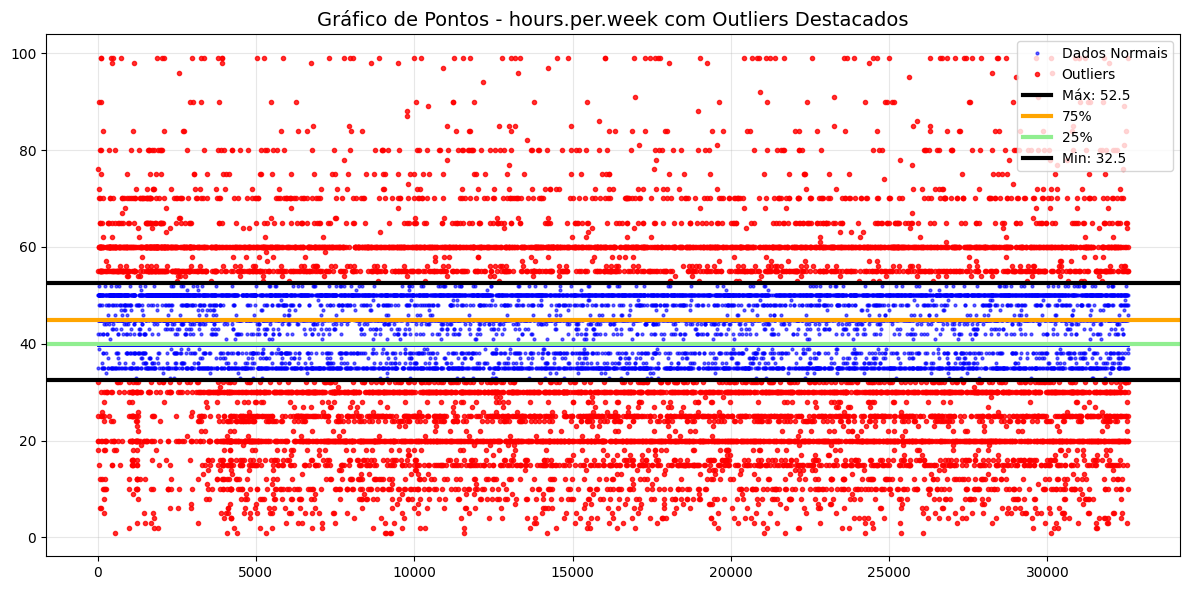

In [5]:
import matplotlib.pyplot as plt
def analisardor_outlier_num(feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    min = Q1 - 1.5 * IQR
    max = Q3 + 1.5 * IQR

    if min < 0:
        min = 0

    outliers = df[(df[feature] < min) | (df[feature] > max)]
    nao_outliers = df[(df[feature] >= min) & (df[feature] <= max)]

    print(f"Intervalo de valores não outliers: {min:.2f} ~ {max:.2f}")
    print(f"Total de outliers: {len(outliers)}\n")
    print(df[feature].describe())

    plt.figure(figsize=(12, 6))

    plt.plot(nao_outliers.index, nao_outliers[feature], 
            'o', markersize=2, alpha=0.6, color='blue', label='Dados Normais')

    plt.plot(outliers.index, outliers[feature], 
            'o', markersize=3, alpha=0.8, color='red', label='Outliers')

    plt.axhline(y=max, color='black', linestyle='-', linewidth=3, label=f'Máx: {max:.1f}')

    plt.axhline(y=Q3, color='orange', linestyle='-', linewidth=3, label=f'75%')

    plt.axhline(y=Q1, color='lightgreen', linestyle='-', linewidth=3, label=f'25%')

    plt.axhline(y=min, color='black', linestyle='-', linewidth=3, label=f'Min: {min:.1f}')

    plt.title(f'Gráfico de Pontos - {feature} com Outliers Destacados', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

feature = "hours.per.week"
analisardor_outlier_num(feature)

# Análise pós-separação treino-teste

### ***Função usada para analisar relação entre features X target***

In [13]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    min_dim = np.min(confusion_matrix.shape) - 1
    v = np.sqrt(chi2 / (n * min_dim))
    return v

def analise_associacao_com_income(df, features_analise):
    resultados = {}

    print("Feature qualitativa/categórica = Qc🔹")
    print("Feature quantitativa/numérica = Qn🔸\n")
    
    for feature in features_analise:
        if feature != 'income':
            if df[feature].dtype in ['object', 'category']:
                v = cramers_v(df[feature], df['income'])
                resultados[feature] = v
                print(f"Qc🔹 {feature:<20} | V de Cramer: {v:.3f}")
                
            else:
                # Variável numérica: usar correlação point-biserial
                # Primeiro mapear income para numérico
                income_numerico = df['income'].map({'<=50K': 0, '>50K': 1})
                corr, p_val = stats.pointbiserialr(df[feature], income_numerico)
                resultados[feature] = abs(corr)  # Valor absoluto
                print(f"Qn🔸 {feature:<20} | Correlação: {corr:.3f} (p-value: {p_val:.3f})")
    
    return resultados

# USO PRÁTICO:
# Todas as features do dataset (incluindo income)
todas_features = ['age', 'workclass', 'education', 'education.num',
                  'marital.status', 'occupation', 'relationship',
                  'race', 'sex', 'hours.per.week', 'income',
                  "capital.gain", "capital.loss"]

# Analisar associação de cada feature com income
resultados_income = analise_associacao_com_income(df, todas_features)

Feature qualitativa/categórica = Qc🔹
Feature quantitativa/numérica = Qn🔸

Qn🔸 age                  | Correlação: 0.235 (p-value: 0.000)
Qc🔹 workclass            | V de Cramer: 0.159
Qc🔹 education            | V de Cramer: 0.365
Qn🔸 education.num        | Correlação: 0.336 (p-value: 0.000)
Qc🔹 marital.status       | V de Cramer: 0.455
Qc🔹 occupation           | V de Cramer: 0.345
Qc🔹 relationship         | V de Cramer: 0.461
Qc🔹 race                 | V de Cramer: 0.102
Qc🔹 sex                  | V de Cramer: 0.221
Qn🔸 hours.per.week       | Correlação: 0.233 (p-value: 0.000)
Qn🔸 capital.gain         | Correlação: 0.223 (p-value: 0.000)
Qn🔸 capital.loss         | Correlação: 0.149 (p-value: 0.000)


### ***Resposta Extra(Verificar se é válida as descrições)***:

* Features com maior associação ao target(Income)

As features com maior associação que encontrei são features categóricas, sendo:

    - marital.status

Valor Cramer V com o target = 0.45 | Pouco associado à feature education, mas é bastante associado com relationship, que é bem associado à education

    - education
    
Valor Cramer V com o target = 0.37 | Pouco associado à feature marital.status, mas é bastante associado com relationship, que é bem associado à marital.status

    - relationship

Valor Cramer V com o target = 0.46 | Bem associado à education e marital.status

In [57]:
count = 0
dic = {}
for data in df["native.country"]:
    if data in dic:
        dic[data] += 1
    else:
        dic[data] = 1

print(dic)

{'United-States': 29170, nan: 583, 'Mexico': 643, 'Greece': 29, 'Vietnam': 67, 'China': 75, 'Taiwan': 51, 'India': 100, 'Philippines': 198, 'Trinadad&Tobago': 19, 'Canada': 121, 'South': 80, 'Holand-Netherlands': 1, 'Puerto-Rico': 114, 'Poland': 60, 'Iran': 43, 'England': 90, 'Germany': 137, 'Italy': 73, 'Japan': 62, 'Hong': 20, 'Honduras': 13, 'Cuba': 95, 'Ireland': 24, 'Cambodia': 19, 'Peru': 31, 'Nicaragua': 34, 'Dominican-Republic': 70, 'Haiti': 44, 'El-Salvador': 106, 'Hungary': 13, 'Columbia': 59, 'Guatemala': 64, 'Jamaica': 81, 'Ecuador': 28, 'France': 29, 'Yugoslavia': 16, 'Scotland': 12, 'Portugal': 37, 'Laos': 18, 'Thailand': 18, 'Outlying-US(Guam-USVI-etc)': 14}


In [3]:
for data in df:
    print(data)

age
workclass
education
education.num
marital.status
occupation
relationship
race
sex
capital.gain
capital.loss
hours.per.week
income


In [16]:
from pathlib import Path

base_path = Path.cwd()

from projeto.dataset import load_processed_datasets

X, y, X_train, X_test, y_train, y_test = load_processed_datasets(base_path)

X_train_subset = X_train.sample(n=10, random_state=42)
y_train_subset = (y_train.loc[X_train_subset.index] == '>50K').astype(int)

y_train = (y_train == '>50K').astype(int)
y_test = (y_test == '>50K').astype(int)